In [1]:
from scipy import special as sp
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
import miepython
import pandas as pd
import csv
import qutip as qp
from scipy.integrate import solve_ivp

## Import Data

In [2]:
def import_data(filename): # filename must contain quotations and format!
    
    """ Imports wavelength and index of refraction data from a csv file with name FILENAME with three columns storing wavelengths, 
        real and complex components of the refractive index, respectively. """
    
    df = pd.read_csv(filename, sep = ',')

    # Read values of wavelength and index of refraction

    ref_lam = df.iloc[0:,0]
    ref_n = df.iloc[0:,1]   # real index of refraction
    ref_k = df.iloc[0:,2]   # complex index of refraction

    # Convert data into arrays

    ref_lam = ref_lam.to_numpy()
    ref_n = ref_n.to_numpy()
    ref_k = ref_k.to_numpy()
    
    return ref_lam, ref_n, ref_k

## Preliminary - Bessel functions

In [3]:
def psi(x, order = 1): # of the first kind
    
    """Defines Ricatti-Bessel spherical function of the first kind."""
    
    psi = np.sqrt(np.pi*x/2) * sp.jv(order + 1/2,x)
    return psi

def c(x, order = 1, second_kind = False):
    
    """Defines Ricatti-Bessel spherical function of the first/second kind."""
    
    if second_kind:
        return np.sqrt(np.pi*x/2) * (sp.jv(order + 1/2,x) - 1j*sp.yv(order + 1/2,x)) # spherical Hankel function of the second kind
        
    return np.sqrt(np.pi*x/2) * (sp.jv(order + 1/2,x) + 1j*sp.yv(order + 1/2,x)) # spherical Hankel function of the first kind

def psi_prime(x, order = 1):

    """Finds first order derivative of Ricatti-Bessel spherical functions of the first kind."""
    
    psi_prime = np.sqrt(np.pi*x/2) * (sp.jv(order-1/2, x) - (order/x) * sp.jv(order + 1/2, x))
    
    return psi_prime

def c_prime(x, order = 1, second_kind = False):
    
    """Computes first order derivative of Ricatti-Bessel spherical functions of the first/second kind."""

    if second_kind:
        c_prime = np.sqrt(np.pi*x/2) * (sp.jv(order - 1/2,x) - 1j*sp.yv(order - 1/2,x) - \
                  (order/x) * (sp.jv(order + 1/2,x) - 1j*sp.yv(order + 1/2,x)))
    else:
        c_prime = np.sqrt(np.pi*x/2) * (sp.jv(order - 1/2,x) + 1j*sp.yv(order - 1/2,x) - \
                  (order/x) * (sp.jv(order + 1/2,x) + 1j*sp.yv(order + 1/2,x)))
    return c_prime


## First-order Mie scattering coefficients (Two different sources)

In [4]:
def wavenumber(lam, n = 1):
    
    """ Calculates wave number of a wave of wavelength lam propagating in a medium of refractive index n. The default 
        medium is vacuum. """
    
    k = 2 * np.pi * n / lam  
    
    return k

In [5]:
def a_1_b_1_lists(ref_ind, lam_list, r, n = 1, order = 1, YSK = False, Thovsen = False):   
    
    """ Outputs lists of a_1 and b_1 Mie scattering coefficients as defined in YSK paper for an input list of wavelengths and corresponding
        refractive indices.
    
        m - list of refractive indices [dimensionless]
        lam_list - list of wavelengths corresponding to refr_ind [μm]
        r - radius of particle [μm]
        n - index of refraction of surrounding medium; vacuum by default [dimensionless] """
        
    k = wavenumber(lam_list, n)   
    rho1 = k * r
    rho2 = ref_ind * k * r
    eps1 = n**2
    eps2 = ref_ind**2
    j_rho1 = sp.spherical_jn(n = order, z = rho1, derivative=False)
    j_rho2 = sp.spherical_jn(n = order, z = rho2, derivative=False)
    y_rho1 = sp.spherical_yn(n = order, z = rho1, derivative=False)
    y_rho2 = sp.spherical_yn(n = order, z = rho2, derivative=False)
    j_prime_rho1 = sp.spherical_jn(n = order, z = rho1, derivative = True)
    j_prime_rho2 = sp.spherical_jn(n = order, z = rho2, derivative = True)
    y_prime_rho1 = sp.spherical_yn(n = order, z = rho1, derivative = True)
    y_prime_rho2 = sp.spherical_yn(n = order, z = rho2, derivative = True)

    h1_rho1 = j_rho1 + 1j*y_rho1
    h1_rho2 = j_rho2 + 1j*y_rho2
    h1_prime_rho1 = j_prime_rho1 + 1j*y_prime_rho1
    h1_prime_rho2 = j_prime_rho2 + 1j*y_prime_rho2
    
    psi_rho1 = rho1*j_rho1
    psi_rho2 = rho2*j_rho2
    psi_prime_rho1 = rho1*j_prime_rho1 + j_rho1
    psi_prime_rho2 = rho2*j_prime_rho2 + j_rho2
            
    xi_rho1 = rho1*h1_rho1
    xi_rho2 = rho2*h1_rho2
    xi_prime_rho1 = rho1*h1_prime_rho1 + h1_rho1
    xi_prime_rho2 = rho2*h1_prime_rho2 + h1_rho2

    h2_rho1 = j_rho1 - 1j*y_rho1 # spherical Hankel function of the second kind
    h2_prime_rho1 = j_prime_rho1 - 1j*y_prime_rho1 # spherical Hankel function of the second kind
    xi_rho1_sk = rho1*h2_rho1 
    xi_pr_rho1_sk = rho1*h2_prime_rho1 + h2_rho1 
    
    if YSK:
        # A and B exchanged to comply with Thovsen conventions for Mie expansions
        numerator_B = j_rho1*psi_prime_rho2 - j_rho2*psi_prime_rho1
        denominator_B = j_rho2*xi_prime_rho1 - h1_rho1*psi_prime_rho2
        numerator_A = eps1*j_rho1*psi_prime_rho2 - eps2*j_rho2*psi_prime_rho1
        denominator_A = eps2*j_rho2*xi_prime_rho1 - eps1*h1_rho1*psi_prime_rho2

    if Thovsen:
        numerator_A = psi_prime_rho2 * psi_rho1 - ref_ind * psi_rho2 * psi_prime_rho1
        denominator_A = psi_prime_rho2 * xi_rho1_sk - ref_ind * psi_rho2 * xi_pr_rho1_sk
        numerator_B = ref_ind * psi_prime_rho2 * psi_rho1 - psi_rho2 * psi_prime_rho1
        denominator_B = ref_ind * psi_prime_rho2 * xi_rho1_sk - psi_rho2 * xi_pr_rho1_sk
        
    A_1 = numerator_A / denominator_A
    B_1 = numerator_B / denominator_B
    return A_1, B_1

## Evaluating Scattering and Extinction Cross Sections

In [6]:
def sca_cross_section_analytical(a_1, b_1, ref_lam):
    
    """ Calculates scattering cross section for a range of a_1 and b_1 Mie scattering coefficients which correspond
    to a list of wavelengths ref_lam [in μm]. """
        
    mod_a_1 = np.abs(a_1)
    mod_b_1 = np.abs(b_1)
    
    qsca = 3 * (ref_lam**2) * (mod_a_1**2 + mod_b_1**2) / (2*np.pi)
    
    return qsca

def ext_cross_section_analytical(a_1, b_1, ref_lam):
    
    """ Calculates extinction cross section for a range of a_1 and b_1 Mie scattering coefficients which correspond
    to a list of wavelengths ref_lam [in μm]. """
    
    qext = 3 * (ref_lam**2) *  np.real(a_1 + b_1) / (2*np.pi)
    
    return qext

## Plotting Cross Sections

In [7]:
def plot_cross_section(lam_list, cross_section1, cross_section2 = None, cross_section3 = None, 
                       figtitle = 'Scattering Cross Section', label1 = 'full', label2 = 'electric + magnetic dipole',
                       label3 = 'electric dipole', xlim = [300,1000], color1 = 'k', color2 = 'purple', color3 = 'b',
                       savefig = False, savefigtitle = 'scattering_cross_section_plot.pdf'):
    
    """ Plots up to three cross sections on the same figure. Labels, title, colors of lines and wavelength limits can 
    be set. If savefig is set to True, the function will save the plot in a pdf file with savefigtitle as title. """
    
    fig, ax = plt.subplots(1,1,figsize=(12, 7))

    ax.plot(lam_list * 1000, cross_section1, linestyle='-', marker = 'o', color = color1, label = label1)
    
    if cross_section2.any() != None:
        ax.plot(lam_list * 1000, cross_section2, linestyle='-', marker = 's', color = color2, label = label2) 
   
    if cross_section3.any() != None:
        ax.plot(lam_list * 1000, cross_section3, linestyle='-', marker = 'x', color = color3, label = label3) 

    ax.set_xlabel('Wavelength [nm]', fontsize = 'x-large')
    ax.set_ylabel('Cross Section [µm²]', fontsize = 'x-large')
    ax.set_title(figtitle, fontsize = 'xx-large')
    plt.xlim(xlim)
    ax.legend(fontsize = 'x-large')
    ax.grid()
    
    if savefig:
        plt.savefig(savefigtitle, format="pdf", bbox_inches="tight")

    return True

## Finding Electric Field for Different Points around the Nanosphere

In [8]:
# All functions incorporate only the electric dipole term into Mie scattering calculations. Polarisation is in 
# the x-direction, wave vector: in the z-direction.
# Spherical coordinates: rho, theta, phi, where rho is the radial unit vector rescaled by the wavenumber of the
# incident light

def max_a_1(refr_ind, lam_list, r, n = 1):
    
    """ Finds a_1 coefficient from the Mie scattering formalism that corresponds to the wavelength of maximum scattering.
    
        refr_ind - list of refractive indices [dimensionless]
        lam_list - list of wavelengths that have refr_ind [m]
        r - radius of particle [m]
        n - index of refraction of surrounding medium; vacuum by default [dimensionless] """
   
    a_1_array, b_1_array = a_1_b_1_lists(ref_ind = refr_ind, lam_list = lam_list, r = r, Thovsen = True)

    sca_cross_section_no_mag = sca_cross_section_analytical(a_1_array, 0, lam_list) # no magnetic terms
    
    max_sca = sca_cross_section_no_mag.max()
    index = np.where(sca_cross_section_no_mag == max_sca)
    
    a_1_max = a_1_array[index]
    
    mod_a_1_max = np.abs(a_1_max)
    
    return mod_a_1_max

def max_lam(refr_ind, lam_list, r, n = 1):
    
    """Finds wavelength from input list for which scattering by the nanoparticle is maximum. 
    
        refr_ind - list of refractive indices [dimensionless]
        lam_list - list of wavelengths that have refr_ind [m]
        r - radius of particle [m]
        n - index of refraction of surrounding medium; vacuum by default [dimensionless]"""
  
    a_1_array, b_1_array = a_1_b_1_lists(ref_ind = refr_ind, lam_list = lam_list, r = r, Thovsen = True)

    sca_cross_section_no_mag = sca_cross_section_analytical(a_1_array, 0, lam_list)
    max_sca = sca_cross_section_no_mag.max()
    index = np.where(sca_cross_section_no_mag == max_sca)
    lam_max = lam_list[index]
    
    return lam_max 

def spherical_coords(x, y, z, lam_max, n = 1): #lam_max = wavelength for maximum scattering
    
    """Transforms Cartesian coordinates into spherical coordinates.
    
        x,y,z - input coordinates [m]
        lam_max - incident wavelength [m] 
        n - index of refraction of surrounding medium; vacuum by default [dimensionless]"""
        
    k = wavenumber(lam_max, n)  
    radius_coord = np.sqrt(x**2 + y**2 + z**2)
    
    rho = k*radius_coord      
    theta = np.arctan(np.sqrt(x**2 + y**2)/z)
    phi = np.arctan(y/x)
    
    return rho, theta, phi

# Define components of scattered field in spherical coordinates

def E_radial(x, y, z, lam_max, a_1_max, n = 1): 
    
    """Finds normalised radial component (E_r / E_0) of scattered field in spherical coordinates. [in V/m]
    
        x,y,z - input Cartesian coordinates [m]
        lam_max - incident wavelength [m] 
        a_1_max - a_1 coefficient for incident lam_max [dimensionless]
        n - index of refraction of surrounding medium; vacuum by default [dimensionless]"""
    
    rho, theta, phi = spherical_coords(x, y, z, lam_max, n)
    E_r = 3 * a_1_max * np.sqrt(np.pi/(2*rho)) * (sp.jv(3/2,rho) + 1j * sp.yv(3/2,rho)) * np.cos(phi) * np.sin(theta) / rho
    
    return E_r 

def E_theta(x, y, z, lam_max, a_1_max, n = 1): 
    
    """Finds normalised theta component (E_theta / E_0) of scattered field in spherical coordinates. [in V/m]
    
        x,y,z - input Cartesian coordinates [m]
        lam_max - incident wavelength [m] 
        a_1_max - a_1 coefficient for incident lam_max [dimensionless]
        n - index of refraction of surrounding medium; vacuum by default [dimensionless] """
    
    rho, theta, phi = spherical_coords(x, y, z, lam_max, n)
    
    hankel1_2 = sp.jv(1/2, rho) + 1j*sp.jv(1/2, rho)
    hankel3_2 = sp.jv(3/2, rho) + 1j*sp.jv(3/2, rho)

    E_theta = (3/2) * a_1_max * np.sqrt(np.pi/(2*rho)) * np.cos(phi) * np.cos(theta) * (hankel1_2 - hankel3_2/rho)
    
    return E_theta

def E_phi(x, y, z, lam_max, a_1_max, n = 1):  
    
    """ Finds normalised phi component (E_phi / E_0) of scattered field in spherical coordinates. [in V/m]
    
        x,y,z - input Cartesian coordinates [m]
        lam_max - incident wavelength [m] 
        a_1_max - a_1 coefficient for incident lam_max [dimensionless]
        n - index of refraction of surrounding medium; vacuum by default [dimensionless] """

    rho, theta, phi = spherical_coords(x, y, z, lam_max, n)
    
    hankel1_2 = sp.jv(1/2, rho) + 1j*sp.jv(1/2, rho)
    hankel3_2 = sp.jv(3/2, rho) + 1j*sp.jv(3/2, rho)
    
    E_phi = (-3/2) * a_1_max * np.sqrt(np.pi/(2*rho)) * np.sin(phi) * (hankel1_2 - hankel3_2/rho)
    
    return E_phi

# Input Cartesian coordinates, output components of scattered field in spherical coordinates

def scattered_field_spherical(x, y, z, refr_ind, lam_max, r, a_1_max, n = 1): 
    
    """ Outputs all three normalised components of scattered field in spherical coordinates. [in V/m]
    
        x,y,z - input Cartesian coordinates [m]
        refr_ind - list of refractive indices [dimensionless]
        lam_max - incident wavelength [m] 
        a_1_max - a_1 coefficient for incident lam_max [dimensionless]
        n - index of refraction of surrounding medium; vacuum by default [dimensionless] """
    
    E_r = E_radial(x, y, z, lam_max, a_1_max, n)
    E_th = E_theta(x, y, z, lam_max, a_1_max, n)
    E_ph = E_phi(x, y, z, lam_max, a_1_max, n)
    
    return E_r, E_th, E_ph   # all in terms of rho, theta, phi

In [9]:
def scattered_field_cartesian(x, y, z, refr_ind, lam_list, r, lam_value = None, n = 1, 
                              absolute_value = True):
    
    """ Outputs normalised complex/absolute values of components of scattered field in Cartesian coordinates. [in V/m]
    
        x,y,z - input Cartesian coordinates [m]
        refr_ind - list of refractive indices [dimensionless]
        lam_list - list of wavelengths corresponding to refr_ind [m]
        r - radius of particle [m]
        lam_value - incident wavelength from list of wavelengths [m]
                    If lam_value is omitted, the code computes components of scattered field for the frequency 
                    of maximum scattering.
        n - index of refraction of surrounding medium; vacuum by default [dimensionless]
        
        absolute_value - If true, the modulus of the component fields is outputed. """

    if lam_value == None:
        # Find parameters at resonance
        a_1_max = max_a_1(refr_ind, lam_list, r, n = 1)
        lam_max = max_lam(refr_ind, lam_list, r, n = 1)
    else:
        index = np.where(lam_list == lam_value)
        m_value = refr_ind[index]
        a_1_max, b_1_max = a_1_b_1_lists(ref_ind = m_value, lam_list = lam_value, r = r, Thovsen = True)  
        lam_max = lam_value #* 0.000001 # rescale from micrometers to nanometers

    E_r, E_th, E_ph = scattered_field_spherical(x, y, z, refr_ind, lam_max, r, a_1_max, n)
    
    rho, theta, phi = spherical_coords(x, y, z, lam_max, n)
    
    E_x = E_r * np.sin(theta) * np.cos(phi) + E_th * np.cos(theta) * np.cos(phi) - E_ph * np.sin(phi)
    E_y = E_r * np.sin(theta) * np.sin(phi) + E_th * np.cos(theta) * np.sin(phi) + E_ph * np.cos(phi)
    E_z = 1 + E_r * np.cos(theta) - E_th * np.sin(theta)
    
    if absolute_value:
        E_x = np.abs(E_x)
        E_y, = np.abs(E_y)
        E_z = np.abs(E_z)
    
    return E_x, E_y, E_z

# Find normalised absolute value of field at given point (x,y,z)

def scattered_field_absolute(x, y, z, refr_ind, lam_list, r, lam_value = None, n = 1):
    
    """ Calculates the absolute value of the scattered field at input points (x,y,z). [in V/m]
        
        x,y,z - input Cartesian coordinates [m]
        refr_ind - list of refractive indices [dimensionless]
        lam_list - list of wavelengths corresponding to refr_ind [m]
        r - radius of particle [m]
        lam_value - incident wavelength from list of wavelengths [m]
                    If lam_value is omitted, the code computes components of scattered field for the frequency 
                    of maximum scattering.
                  
        n - index of refraction of surrounding medium; vacuum by default [dimensionless] """

    E_x, E_y, E_z = scattered_field_cartesian(x, y, z, refr_ind, lam_list, r, lam_value, n, absolute_value = True)

    E = np.sqrt(E_x**2 + E_y**2 + E_z**2)
    
    return E

## Plotting Scattered Field

In [10]:
def plot_scattered_field(x_points, y_points, z, refr_ind, lam_list, r, filename = 'defaultFile.txt', 
                         lam_value = None, n = 1): 
    
    """ Function calculates normalised scattered field along a cross section of the nanosphere. It outputs a txt file 
    with field values for the different coordinates, and a plot of the cross section.
    
        x_points, y_points - arrays of points for which scattering is calculated [nm]
        z - fixed coordinate that defines the plane of cross section [nm]
        
        refr_ind - list of refractive indices 
        lam_list - list of wavelengths corresponding to refr_ind, in [μm]
        r - radius of particle [μm]
        filename - name for txt file with coordinates and field values that the function will create
        lam_value - specific wavelength of the incident light; must be in the list of wavelengths [μm]
                    If lam_value is omitted, the scattering is performed at the frequency of maximum scattering.
        n - index of refraction of surrounding medium; vacuum by default """
    
    # Rescale coordinates to meters
    x_vals = x_points * 1.0e-9
    y_vals = y_points * 1.0e-9
    z_val = z * 1.0e-9

    if lam_value != None:
        if lam_value not in lam_list:
            print("Refractive index for this wavelength is not known. Please, choose wavelength from the input list of wavelengths.")
    
    # Rescale input parameters to meters
    lam_vals = lam_list * 1.0e-6
    lam_val = lam_value * 1.0e-6
    rad = r * 1.0e-6
    
    # Create txt file with coordinate values
    f = open(filename,'w')
    f.write("# X [nm] , Y [nm], E/E_0 \n")
    coord = []
    
    # Build arrays of points and scattered fields
    colors = np.array([])
    points_x = []
    points_y = []
    
    for j in y_vals:
        for i in x_vals:
            if i**2 + j**2 < rad**2:
                E = [0]
            else:
                E = scattered_field_absolute(i, j, z_val, refr_ind, lam_vals, rad, lam_val, n) # in V/m
            points_x.append(1.0e9*i) # rescale to nm for plot
            points_y.append(1.0e9*j) # rescale to nm for plot
            colors = np.append(colors, E)
            
            c = [1e9*i , 1e9*j , *E]  # coordinates for txt file
            coord.append(c)
            
    # Plot
    fig, ax = plt.subplots(1,1, figsize = (10, 10))
    plt.scatter(points_y, points_x, c=colors, cmap='jet')
    plt.xlabel('X [nm]')
    plt.ylabel('Y [nm]')
    plt.title('Field enhancement in X-Y plane')

    cbar = plt.colorbar(shrink = 0.6)
    cbar.ax.set_title(r'$|E|/|E_0|$')

    ax.set_aspect('equal')

    plt.show()
    plt.savefig("scattered_field_plot.pdf", format="pdf", bbox_inches="tight")
    
    # Write the coordinates in the txt file
    csv.writer(f, delimiter=',').writerows(coord)
    f.close()
    
    # Return values
    if lam_value == None:
        wavelength = f'At incoming wavelength of {1e9 * max_lam(refr_ind, lam_list, r)} nm'
    else:
        wavelength = f'At incoming wavelength of {1e9 * lam_value} nm'
    E_max = f'Maximum scattered field = {colors.max()} E_0'
    
    return wavelength, E_max

## Finding and/or Plotting Components of Scattered Field

In [11]:
def scattered_field_components(x_points, y_points, z, refr_ind, lam_list, r, lam_value = None, n = 1,
                                   plot = True, E_0 = None):
    
    """ Plots the cartesian components of the scattered field at input points. [in V/m]
    
    x_points, y_points - arrays of points for which scattering is calculated [nm]
    z - fixed coordinate that defines the plane of cross section [nm]
    
    refr_ind - list of refractive indices 
    lam_list - list of wavelengths corresponding to refr_ind, in [μm]
    r - radius of particle [μm]
    lam_value - specific wavelength of the incident light; must be in the list of wavelengths [μm]
                If lam_value is omitted, the scattering is performed at the frequency of maximum scattering.
    n - index of refraction of surrounding medium; vacuum by default
    E_0 - amplitude of incident field [au/SI input units determine the output units of the field components]
    
    Boolean:
    plot: if True, output includes plots of the three components """
    
    # Rescale coordinates to meters
    x_points = x_points * 1.0e-9
    y_points = y_points * 1.0e-9
    z = z * 1.0e-9

    if lam_value != None:
        if lam_value not in lam_list:
            print("Refractive index for this wavelength is not known. Please, choose wavelength from the input list.")
        index = np.where(lam_list == lam_value)
        m_value = refr_ind[index]
    else:
        # Find parameters at resonance
        lam_max = max_lam(refr_ind, lam_list, r, n = 1)
        lam_value = lam_max
        index = np.where(lam_list == lam_max)
        m_value = refr_ind[index]
    
    #Rescale input parameters to meters
    lam_list = lam_list * 1.0e-6
    lam_value = lam_value * 1.0e-6
    r = r * 1.0e-6
    
    # Build arrays of points and scattered fields
    E_x_values = np.array([])
    E_y_values = np.array([])
    E_z_values = np.array([])    
    points_x = []
    points_y = []
    
    for j in y_points:
        for i in x_points:
            if i**2 + j**2 < r**2:
                E_x = [0]
                E_y = [0]
                E_z = [0]
            
            else:
                E_x, E_y, E_z = scattered_field_cartesian(i, j, z, refr_ind, lam_list, r, lam_value, n,
                                                          absolute_value = True)
                
            points_x.append(1e9*i) # rescale to nm for plot
            points_y.append(1e9*j) # rescale to nm for plot
            
            E_x_values = np.append(E_x_values, E_x)
            E_y_values = np.append(E_y_values, E_y)
            E_z_values = np.append(E_z_values, E_z)
            
    if plot:
        # Plot    
        fig, ax = plt.subplots(1, 3, figsize = (16,5))    

        ax[0].scatter(points_y, points_x, c=E_x_values, cmap='jet')
        ax[0].set_title('Scattered Field in X Direction')

        ax[1].scatter(points_y, points_x, c=E_y_values, cmap='jet')
        ax[1].set_title('Scattered Field in Y Direction')

        ax[2].scatter(points_y, points_x, c=E_z_values, cmap='jet')
        ax[2].set_title('Scattered Field in Z Direction')
    
        for i in range(3):
            ax[i].set_xlabel('X [nm]')
            ax[i].set_ylabel('Y [nm]')
            ax[i].set_aspect('equal')
        
        fig.suptitle('Components of Scattered Field', y = 1.06, fontsize = 'xx-large', fontweight='bold')
        plt.show()
        plt.savefig("field_components_plot.pdf", format="pdf", bbox_inches="tight")

    # Remove normalisation
    if E_0 != None:
        E_x_values = E_x_values * E_0        
        E_y_values = E_y_values * E_0
        E_z_values = E_z_values * E_0

    return E_x_values, E_y_values, E_z_values, gamma_values

## Calculating decay rates

In [12]:
def gamma_factors(d_points, ref_ind, lam_val, r, n = 1, order = 1, plot = False):   
    
    """ Outputs lists of a_1 and b_1 Mie scattering coefficients and corresponding gamma factors (total and radiative for both vertical
        and horizontal orientations) as defined in YSK paper for an input list of wavelengths and corresponding refractive indices.
 
        d_points - distances from centre of nanosphere at which decay rates are evaluated [m]
        ref_ind - list of refractive indices [dimensionless]
        lam_val - single wavelength (must correspond to some value of m in refr_ind)[m]
        r - radius of particle [m]
        n - index of refraction of surrounding medium; vacuum by default [dimensionless]
        order - number of terms at which to terminate the expansion of gamma 
        plot - if True, plot of gamma as a function of d/r starting from 1
               [distance from surface of sphere in units of r] is produced """

    eps1 = 1.0
    eps2 = ref_ind**2
    k1 = 2 * np.sqrt(eps1) * np.pi / lam_val # surrounding medium (vacuum)
    k2 = 2 * ref_ind * np.pi / lam_val# nanoparticle
    rho1 = k1*r
    rho2 = k2*r

    gamma_norm_vals = np.zeros_like(d_points, dtype = float)
    gamma_tang_vals = np.zeros_like(d_points, dtype = float)
    gamma_norm_rad_vals = np.zeros_like(d_points, dtype = float)
    gamma_tang_rad_vals = np.zeros_like(d_points, dtype = float)
    
    A_list = np.zeros((order,len(d_points)), dtype = complex)
    B_list = np.zeros((order,len(d_points)), dtype = complex)

    j = 0
    for d in d_points:
        #dis = r + d
        y1 = k1*d 

        gamma_norm_sum = 0.0
        gamma_tang_sum = 0.0
        gamma_norm_rad_sum = 0.0
        gamma_tang_rad_sum = 0.0
        for i in range(1,order+1):
            j_rho1 = sp.spherical_jn(n = i, z = rho1, derivative = False)
            j_rho2 = sp.spherical_jn(n = i, z = rho2, derivative = False)
            y_rho1 = sp.spherical_yn(n = i, z = rho1, derivative = False)
            y_rho2 = sp.spherical_yn(n = i, z = rho2, derivative = False)
            h1_rho1 = j_rho1 + 1j*y_rho1
            h1_rho2 = j_rho2 + 1j*y_rho2
            
            j_prime_rho1 = sp.spherical_jn(n = i, z = rho1, derivative = True)
            j_prime_rho2 = sp.spherical_jn(n = i, z = rho2, derivative = True)
            y_prime_rho1 = sp.spherical_yn(n = i, z = rho1, derivative = True)
            y_prime_rho2 = sp.spherical_yn(n = i, z = rho2, derivative = True)
            h1_prime_rho1 = j_prime_rho1 + 1j*y_prime_rho1
            h1_prime_rho2 = j_prime_rho2 + 1j*y_prime_rho2
    
            psi_rho1 = rho1*j_rho1
            psi_rho2 = rho2*j_rho2
            psi_prime_rho1 = rho1*j_prime_rho1 + j_rho1
            psi_prime_rho2 = rho2*j_prime_rho2 + j_rho2
            
            xi_rho1 = rho1*h1_rho1
            xi_rho2 = rho2*h1_rho2
            xi_prime_rho1 = rho1*h1_prime_rho1 + h1_rho1
            xi_prime_rho2 = rho2*h1_prime_rho2 + h1_rho2

            j1_y1 = sp.spherical_jn(n = i, z = y1, derivative = False)
            y1_y1 = sp.spherical_yn(n = i, z = y1, derivative = False)
            h1_y1 = j1_y1 + 1j*y1_y1
            j_prime_y1 = sp.spherical_jn(n = i, z = y1, derivative = True)
            y_prime_y1 = sp.spherical_yn(n = i, z = y1, derivative = True)
            h1_prime_y1 = j_prime_y1 + 1j*y_prime_y1
        
            psi_y1 = y1*j1_y1
            psi_prime_y1 = y1*j_prime_y1 + j1_y1
            xi_y1 = y1*h1_y1
            xi_prime_y1 = y1*h1_prime_y1 + h1_y1

            numerator_A = j_rho1*psi_prime_rho2 - j_rho2*psi_prime_rho1
            denominator_A = j_rho2*xi_prime_rho1 - h1_rho1*psi_prime_rho2

            numerator_B = eps1*j_rho1*psi_prime_rho2 - eps2*j_rho2*psi_prime_rho1
            denominator_B = eps2*j_rho2*xi_prime_rho1 - eps1*h1_rho1*psi_prime_rho2
    
            A_i = numerator_A / denominator_A
            B_i = numerator_B / denominator_B

            A_list[i-1,j] = A_i
            B_list[i-1,j] = B_i

            g_norm_i = (2*i+1)*i*(i+1)*B_i*((h1_y1/y1)**2)
            gamma_norm_sum = gamma_norm_sum + g_norm_i
            g_norm_rad_i = i*(i+1)*(2*i+1)*((abs((j1_y1 + B_i*h1_y1)/y1))**2)
            gamma_norm_rad_sum = gamma_norm_rad_sum + g_norm_rad_i
    
            g_tang_i = (i+0.5)*(B_i*((xi_prime_y1/y1)**2) + A_i*((h1_y1)**2))
            gamma_tang_sum = gamma_tang_sum + g_tang_i
    
            g_tang_rad_i = (2*i+1)*((abs(j1_y1 + A_i*h1_y1))**2 + (abs((psi_prime_y1 + B_i*xi_prime_y1)/y1))**2)
            gamma_tang_rad_sum = gamma_tang_rad_sum + g_tang_rad_i

        gamma_norm = 1 + 1.5*gamma_norm_sum.real
        gamma_tang = 1 + 1.5*gamma_tang_sum.real
        gamma_norm_rad = 1.5*gamma_norm_rad_sum
        gamm_tang_rad = 0.75*gamma_tang_rad_sum
        
        gamma_norm_vals[j] = gamma_norm
        gamma_tang_vals[j] = gamma_tang
        gamma_norm_rad_vals[j] = gamma_norm_rad
        gamma_tang_rad_vals[j] = gamm_tang_rad
        j += 1 

    if plot:
        fig, ax = plt.subplots(1,1, figsize = (9, 9))
        ax.plot(d_points/a, gamma_norm_vals, label = '$\gamma_{\perp}$')
        ax.plot(d_points/a, gamma_tang_vals, label = '$\gamma_{\, \|}$')
        ax.plot(d_points/a, gamma_norm_rad_vals, linestyle = '--', label = '$\gamma^{\, R}_{\perp}$')  
        ax.plot(d_points/a, gamma_tang_rad_vals, linestyle = '--', label = '$\gamma^{\, R}_{\, \|}$')
        ax.set_xlabel('d/a', fontsize=14)
        ax.set_ylabel('$\gamma / \gamma_0$', fontsize=14)
        ax.set_ylim(0,2)
        ax.minorticks_on()
        ax.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=13)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.3)
        ax.grid(alpha = 0.2)
        ax.legend(fontsize=13)
        ax.set_title(f'Decay rates of TLS near spherical nanoparticle of radius a = {a*10**9} nm', fontsize=15, loc = 'center', wrap = True, pad=30)
        plt.show()
    return A_list, B_list, gamma_norm_vals, gamma_tang_vals, gamma_norm_rad_vals, gamma_tang_rad_vals

## Plot evolution

In [116]:
def gn(g_x, kappa_z, order=1):
    return order*(sp.jv(order+1,kappa_z) + sp.jv(order-1,kappa_z))*g_x
    
def constants(E_0 = 0.0001, om_eg = None, x_points = np.array([10.5*(10**-9)]), r = 0.01, wvl = 0.36, ref_ind = None, lam_list = None, \
              order = 1, plot = False, transformed_H = False):
    
    """ Estimates constants required for evolving the density matrix elements. """

    hbar = 1.054571817e-34 # reduced Planck constant[Js]
    c = 299792458 # speed of light [m/s]
    eps_0 = 8.8541878188e-12 # permittivity of free space [F/m]
    a = r * 1e-6 # radius of nanosphere [m]  
    d_eg = 8.4783536198e-30 # transition dipole moment = 1 [au]
    dperm = 0.9*d_eg #0.9*d_eg # permanent dipole moment = 1 [au]

    ### Find gx, gz, gI, gamma ###
    index = np.where(lam_list == wvl)
    mval = ref_ind[index][0]
    lam = wvl*1e-6 #microm --> m --> au
    ref_lams = lam_list*1e-6
    w_c = 2*np.pi*c/lam 
    if om_eg == None:
        w_eg = w_c
    else:
        w_eg = om_eg * (4.3597447222060e-18) / (hbar)    
    E_0val = E_0 * 5.14220675112e11 # Electric field (no enhancement) [V/m]

    gamma_0 = (w_c**3)*(np.abs(d_eg)**2)/(3*np.pi*eps_0*hbar*(c**3))
    A_list, B_list, gamma_norm, gamma_tang, gamma_norm_rad, gamm_tang_rad = gamma_factors(x_points, mval, lam, a, n = 1, \
                                                                                          order = 1, plot = False)

    omega_pr_vals, delta_pr_vals, gamma_pr_vals, gamma_vals, g_x_vals, g_z_vals, \
    g_I_vals = [np.zeros_like(x_points, dtype=float) for _ in range(7)]   # Arrays for storing values of constants

    for x in x_points:
        E_abs = E_0val * scattered_field_absolute(x, 0.0, 1e-15, ref_ind, ref_lams, a, lam, n = 1)  # Enhanced electric field [V/m]
        ind = np.where(x_points == x)[0]
        if len(ind) == 0:
            continue
        else:
            ind = ind[0]
        g_x = E_abs*d_eg/hbar
        g_z = E_abs*dperm/hbar
        g_I = E_abs*dperm/hbar
        gamma = gamma_norm * gamma_0 
        g_x_vals[ind] = g_x[0]
        g_z_vals[ind] = g_z[0]
        g_I_vals[ind] = g_I[0]
        gamma_vals[ind] = gamma[0]

        if transformed_H:
            
            kappa_z = g_z/w_c
            g_x1 = (sp.jv(2,kappa_z) + sp.jv(0,kappa_z))*g_x
        
            kappa_x = g_x1/w_c
        
            def fun(eps):
                return (w_eg*sp.j1(2*eps*kappa_x) - (1-eps)*g_x1) / g_x1
                    
            eps = fsolve(fun, x0 = 0.6)[0]
            #print(eps, w_eg*sp.j1(2*0.6125708129703519*kappa_x) - (1-0.6125708129703519)*g_x1)
            assert np.abs(w_eg*sp.j1(2*eps*kappa_x) - (1-eps)*g_x1) < 1e-1, 'Estimated epsilon equation gives value larger than 1e-1' 
            
            if plot:  
                fig, ax = plt.subplots(1,1,figsize = (3,3))
                for i in np.arange(-0.9*eps,1.1*eps, 0.001):
                    ax.scatter(i, fun(i), marker = '.')
                ax.set_xlabel('eps')
                ax.set_ylabel('f(eps)')
                plt.show()
                
            omega = 2*w_eg*sp.j1(2*eps*kappa_x)
            w_eg_pr = w_eg*sp.j0(2*eps*kappa_x)
        
            g_z_pr = 0.0
            for k in range(1, 10000):
                g_z_pr += 4*k*gn(g_x = g_x, kappa_z = kappa_z, order=2*k)*sp.jv(2*k, 2*eps*kappa_x) / (2*eps*kappa_x)
        
            kappa_z_pr = g_z_pr/w_c
            omega_pr = omega*sp.j0(kappa_z_pr)
            delta_pr = w_c - w_eg_pr
            gamma_pr = gamma*(sp.j0(kappa_z)*sp.j0(kappa_z_pr))**2
            omega_pr_vals[ind] = omega_pr[0]
            delta_pr_vals[ind] = delta_pr[0]
            gamma_pr_vals[ind] = gamma_pr[0]

    if transformed_H:
        return omega_pr_vals, delta_pr_vals, gamma_pr_vals, gamma_vals, g_x_vals, g_I_vals, g_z_vals, w_c, w_eg
    return np.array([0.0]), np.array([0.0]), np.array([0.0]), gamma_vals, g_x_vals, g_I_vals, g_z_vals, w_c, w_eg


In [87]:
ref_lam_silver, ref_n_silver, ref_k_silver = import_data("McPeak_silver.csv")
m_silver = ref_n_silver + 1j * ref_k_silver
omega_pr, delta_pr, gamma_pr, gamma, g_x, g_I, g_z, w_c, w_eg = constants(E_0 = 0.0001, order = 1, ref_ind = m_silver, \
                                                        lam_list = ref_lam_silver, transformed_H = True)
omega_pr, delta_pr, gamma_pr, gamma

(array([7.57178813e+13]),
 array([2.73940282e+11]),
 array([2.12232968e+11]),
 array([2.1225097e+11]))

In [111]:
def qutip_integration(m, lam_vals, x_points = np.array([10.5*(10**-9)]), tf = 10e-15, numtimes = 1000, \
                      E_0 = 0.0001, transformed_H = False, envelope = False, savefig = True):
    g = qp.basis(2, 1)
    rho0 = g * g.dag() # Initially in ground state
    sig_z = qp.sigmaz()
    sig_x = qp.sigmax()
    sig_p = qp.sigmap()
    sig_m = qp.sigmam()
    eye = qp.qeye(2)
    omega_pr_vals, delta_pr_vals, gamma_pr_vals, gamma_vals, g_x_vals, g_I_vals, g_z_vals, w_c, w_eg = \
    constants(E_0, x_points = x_points, order = 1, ref_ind = m, lam_list = lam_vals, transformed_H = transformed_H)
    times = np.linspace(0.0, tf, numtimes)

    fig, ax = plt.subplots(1,1, figsize = (8,5))
    ax.set_xlabel('time [fs]', fontsize=14)
    ax.set_ylabel('$<\sigma_z>$', fontsize=14)
    ax.minorticks_on()
    ax.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=13)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)
    ax.grid(alpha = 0.2)
    
    for i in range(len(gamma_vals)):
        gamma = gamma_vals[i]
        g_x = g_x_vals[i]
        g_I = g_I_vals[i]
        g_z = g_z_vals[i]
        def H1_coeff(t,args):
            return 0.5*w_eg + (0.5*g_z*sig_z + g_x*(sig_p + sig_m) + 0.5*g_I*eye)*np.cos(w_c*t)
    
        if transformed_H:
            omega_pr = omega_pr_vals[i]
            delta_pr = delta_pr_vals[i]
            gamma_pr = gamma_pr_vals[i]
            H = -0.5*delta_pr*sig_z + 0.5*omega_pr*sig_x
            result = qp.mesolve(H, rho0, times, [np.sqrt(gamma_pr) * qp.sigmap()], e_ops=[qp.sigmaz()])     
            if envelope:
                ax.plot(times*1e15, np.exp(-gamma_pr*times), ls = '--', color = 'grey', label = '$e^{-\Gamma t}$')
        else:
            result = qp.mesolve(H1_coeff, rho0, times, [np.sqrt(gamma) * qp.sigmap()], e_ops=[qp.sigmaz()])

        ax.plot(times*1e15, result.expect[0], marker = '.', label = f'd = {x_points[i]*1e9:.1f} nm')

    ax.legend(fontsize=13)
    ax.set_title(f'Evolution of TLS for $E_0 = {E_0* 5.14220675112e11:.2E} V/m$', fontsize=15, wrap = True, pad = 20)
    if savefig:
        plt.savefig(fname = 'evolution.jpg', format = 'jpg')
    plt.show()

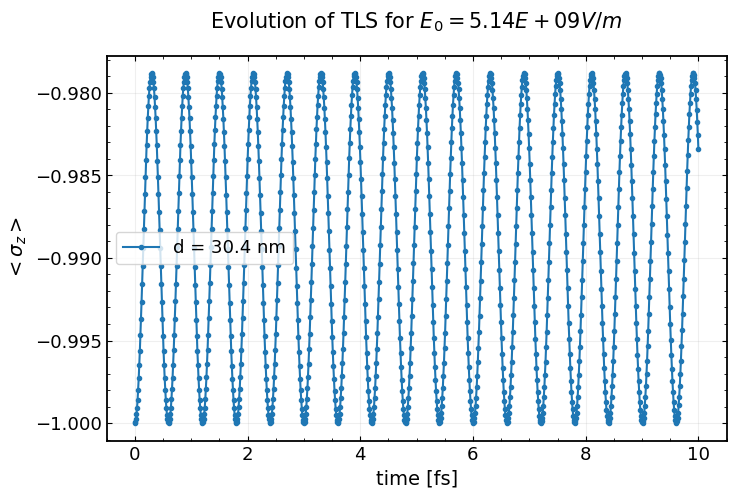

In [113]:
#qutip_integration(m_silver, ref_lam_silver, x_points = np.array([30.4*(10**-9)]), E_0 = 0.01, tf = 10e-15)

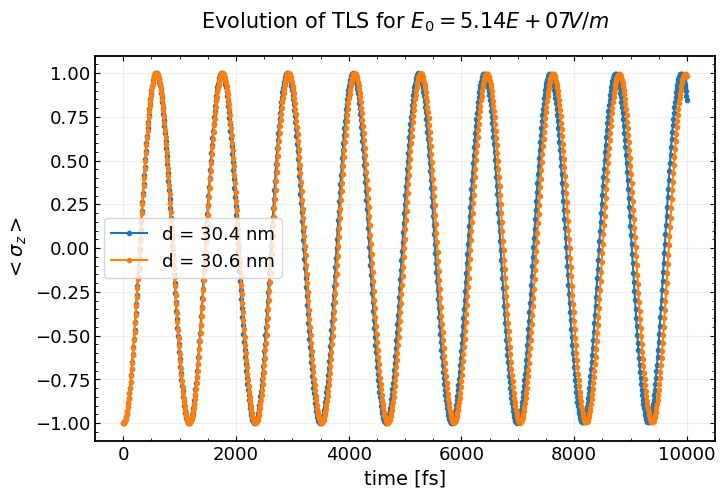

In [97]:
#qutip_integration(m_silver, ref_lam_silver, x_points = np.array([30.4*(10**-9), 30.6*(10**-9)]), E_0 = 0.0001, \
#                  tf = 10000e-15, transformed_H = True)

## Plotting style

In [18]:
def general_plot_style(x, y, legendlabels = None, colors = None, ls = None, figsize = [9,9], ylims = None, xlabel = None, \
                       ylabel = None, title = None, filename = 'default.jpg', savefig = False):
    
    """Generates a standardised plot of X vs Y with ticks on all 4 axes"""
    
    fig, ax = plt.subplots(1,1, figsize = (figsize[0], figsize[1]))
    
    for ind in range(len(x)):
        ax.plot(x[ind], y[ind], label = legendlabels[ind], color = colors[ind], ls = ls[ind])
    #ax.plot(x, y, label = legendlabels[0], color = colors[0], ls = ls[0])
        
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    if ylims != None:
        ax.set_ylim(ylims[0], ylims[1])
    ax.minorticks_on()
    ax.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=13)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)
    ax.grid(alpha = 0.2)
    ax.legend(fontsize=13)
    
    ax.set_title(title, fontsize=15, wrap = True, pad = 30)
    if savefig:
        plt.savefig(fname = filename, format = 'jpg')
    plt.show()